# Total COVID-19 daily cases
Script produced by [Laurent Lessard](https://laurentlessard.com)

---

### Import data from JHU CSSE

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import datetime
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

mpl.rcParams['figure.dpi'] = 120

# get country data
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df_raw = pd.read_csv(url)

# get country populations
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"
df_pop = pd.read_csv(url, index_col="Combined_Key", usecols=["Combined_Key", "Population"]).Population

### Reformat data into convenient form

In [2]:
colnames = df_raw.columns

# aggregate by region
df = df_raw.pivot_table(index='Country/Region',values=colnames[4:],aggfunc=sum)

# make countries columns rather than rows
df = df.T

# make the index a datetime object
df = df.reindex( pd.to_datetime(df.index) )

# sort the dates/times
df.sort_index(inplace=True)

# record the latest date
latest_date = df.index[-1].strftime("%a %b %d, %Y")
print(latest_date)

Fri Nov 20, 2020


### List of countries with the most confirmed cases

In [3]:
cases_total = df.max() * 1.0
for name,cases in cases_total.items():
    cases_total[name] /= df_pop[name]
cases_sorted = cases_total.sort_values(ascending=False)
cases_sorted.head(15)

Country/Region
Andorra        0.079493
Bahrain        0.050228
Montenegro     0.047892
Belgium        0.047774
Luxembourg     0.047545
Qatar          0.047513
Czechia        0.045528
Armenia        0.041727
San Marino     0.041104
Israel         0.037866
US             0.036152
Panama         0.035295
Switzerland    0.033578
Holy See       0.033375
Spain          0.033296
dtype: float64

### List of countries with the most daily cases

In [4]:
daily_cases_total = df.diff().max() * 1.0
for name,cases in daily_cases_total.items():
    daily_cases_total[name] /= df_pop[name]
daily_cases_sorted = daily_cases_total.sort_values(ascending=False)
daily_cases_sorted.head(20)

Country/Region
Holy See             0.008653
Andorra              0.003870
Luxembourg           0.003142
Switzerland          0.002533
San Marino           0.002239
Belgium              0.002064
France               0.001921
Kyrgyzstan           0.001763
Sweden               0.001562
Czechia              0.001469
Montenegro           0.001392
Israel               0.001307
Liechtenstein        0.001285
Slovenia             0.001256
Equatorial Guinea    0.001247
Spain                0.001177
Austria              0.001064
Kosovo               0.001026
Kazakhstan           0.000999
Georgia              0.000945
dtype: float64

In [5]:
# Country group for European Union
idx_EUK = ["Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark",
          "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland",
          "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland",
          "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden", "United Kingdom"]
df["EU + UK"] = df[idx_EUK].sum(axis="columns")
df_pop["EU + UK"] = df_pop[idx_EUK].sum()


# Country group for South America
idx_SA = ["Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador",
          "Guyana", "Paraguay", "Peru", "Suriname", "Uruguay", "Venezuela"]
df["South America"] = df[idx_SA].sum(axis="columns")
df_pop["South America"] = df_pop[idx_SA].sum()

### Plot daily confirmed cases

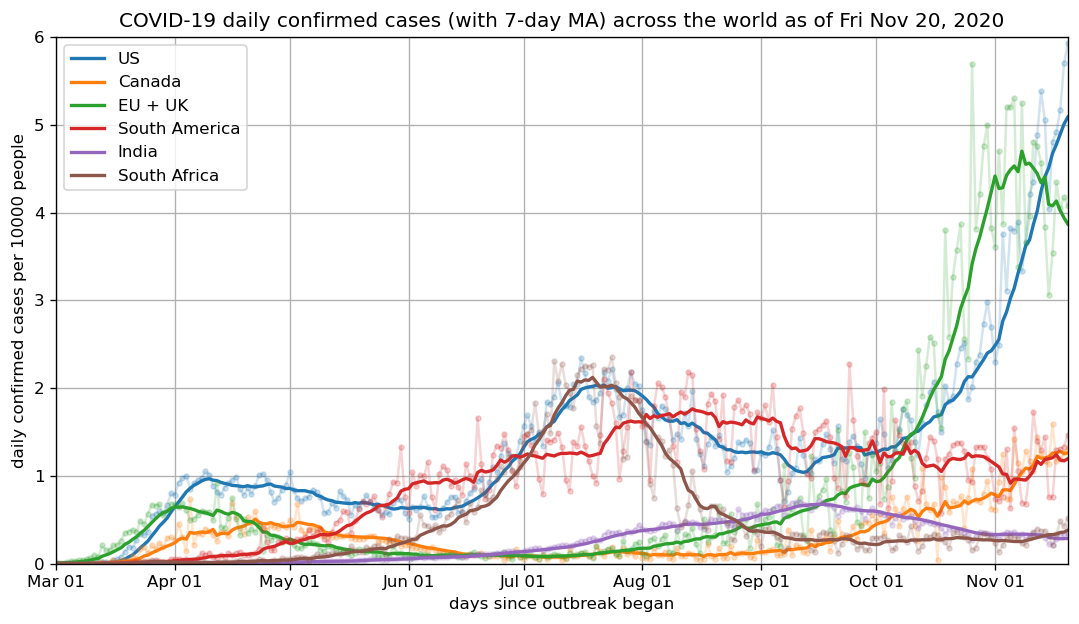

In [8]:
plt.figure(figsize=(9,5))
ax = plt.gca()

# selected countries
countries = ['US','Canada','EU + UK','South America', 'India', 'South Africa']
# countries = cases_sorted[:6].index
min_cases = 1
pop_scale = 10000

# shift data so that index corresponds to days since min_cases cases.
# shifted_data = shift_data( countries, min_cases )
# data_len = max([len(dat) for dat in shifted_data])

# xmax = data_len

for name in countries:
    data = df[name]
    color = next(ax._get_lines.prop_cycler)['color']
    population = df_pop[name]
    plt.plot( data.diff() / population * pop_scale, marker=".", label=None, color=color, alpha=0.2 )
    plt.plot( data.diff().rolling(7).mean() / population * pop_scale, marker="", label=name, color=color, linewidth=2 )

# make plot
ax.set_title("COVID-19 daily confirmed cases (with 7-day MA) across the world as of %s" % latest_date)
ax.legend(loc="upper left")
ax.set_xlabel("days since outbreak began" )
ax.set_ylabel(f"daily confirmed cases per {pop_scale} people")
ax.grid()

date_format = "%b %d"
ax.xaxis.set_major_formatter(DateFormatter(date_format))
ax.autoscale(enable=True, axis='x', tight=True)
date_start = datetime.date(2020, 3, 1)
# date_end   = datetime.date(2020, 10, 1)
plt.xlim(xmin=date_start)

plt.ylim(ymin=0,ymax=6)    
plt.tight_layout(pad=0)

plt.savefig("figures/world_daily_cases.png")

In [9]:
df.diff().rolling(7).mean().iloc[-1] 

Country/Region
Afghanistan         210.571429
Albania             679.714286
Algeria             968.571429
Andorra              59.571429
Angola              148.428571
                     ...      
Yemen                 2.571429
Zambia               40.000000
Zimbabwe             50.714286
EU + UK          198531.428571
South America     51463.857143
Name: 2020-11-20 00:00:00, Length: 193, dtype: float64

In [10]:
df[['Austria','Belgium']]

Country/Region,Austria,Belgium
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2020-11-16,208613,537871
2020-11-17,214597,540605
2020-11-18,221688,545787
2020-11-19,228683,550264


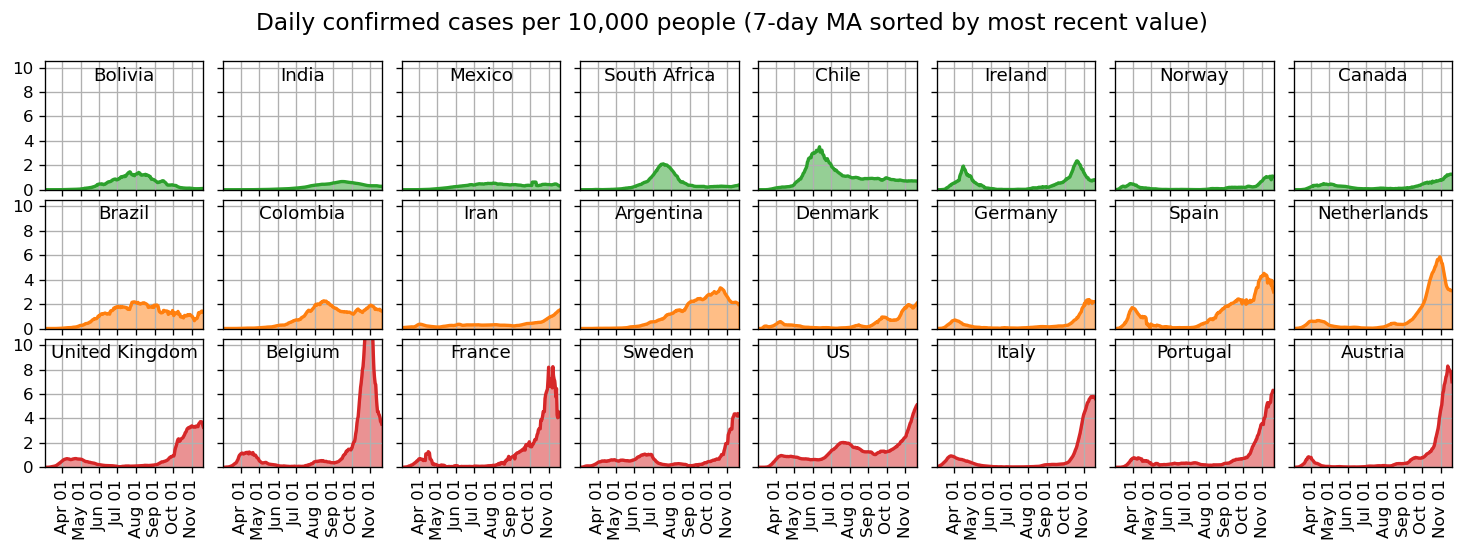

In [16]:
interesting = ['Austria','Belgium','Canada','Denmark','France','Germany','Ireland','Italy',
               'Netherlands','Norway','Spain','United Kingdom','Iran','Portugal','Sweden',
               'US','Argentina','Bolivia','Brazil','Chile','Colombia','India','Mexico','South Africa']

data_normalized = df[interesting].diff().rolling(7).mean().iloc[-1] / df_pop[interesting]
country_order = data_normalized.sort_values().index


fig,axs = plt.subplots(3,8, figsize=(12,4), sharey=True, sharex=True)

pop_scale = 10000

for ix,name in enumerate(country_order):
    if ix < 8:
        col = "C2"
    elif ix < 16:
        col = "C1"
    else:
        col = "C3"
    ax = axs.reshape(-1)[ix]
    data = df[name]
    population = df_pop[name]
    ax.fill_between( x=data.index, y1=data.diff().rolling(7).mean() / population * pop_scale, alpha=0.5, color=col )
    ax.plot( data.diff().rolling(7).mean() / population * pop_scale, label=name, linewidth=2, color=col )
    txt = ax.text(.5,.85, name,
            horizontalalignment='center',
            transform=ax.transAxes,
            fontsize=11)
    ax.grid()
    date_format = "%b %d"
    ax.xaxis.set_major_formatter(DateFormatter(date_format))
    ax.autoscale(enable=True, axis='x', tight=True)
    date_start = datetime.date(2020, 3, 3)
#     date_end   = datetime.date(2020, 7, 1)
    ax.set_xlim(xmin=date_start)
    
    months = mdates.MonthLocator()  # every month
    ax.xaxis.set_major_locator(months)
    
    ax.set_ylim(ymin=0,ymax=10.5)
    ax.set_yticks(range(0,11,2))

fig.autofmt_xdate(rotation=90, ha='center')
my_suptitle = fig.suptitle("Daily confirmed cases per 10,000 people (7-day MA sorted by most recent value)", fontsize=14, y=1.1)

plt.tight_layout(pad=0)
plt.savefig("figures/world_daily_cases_breakdown.png", dpi=fig.dpi, bbox_inches='tight', bbox_extra_artists=[my_suptitle])